### Data fields

<ul>
    <li>Home Ownership</li>
    <li>Annual Income - годовой доход</li>
    <li>Years in current job - количество лет на текущем месте работы</li>
    <li>Tax Liens - налоговые обременения</li>
    <li>Number of Open Accounts - количество открытых счетов</li>
    <li>Years of Credit History - количество лет кредитной истории</li>
    <li>Maximum Open Credit - наибольший открытый кредит</li>
    <li>Number of Credit Problems - количество проблем с кредитом</li>
    <li>Months since last delinquent - количество месяцев с последней просрочки платежа</li>
    <li>Bankruptcies - банкротства</li>
    <li>Purpose - цель кредита</li>
    <li>Term - срок кредита</li>
    <li>Current Loan Amount - текущая сумма кредита</li>
    <li>Current Credit Balance - текущий кредитный баланс</li>
    <li>Monthly Debt - ежемесячный долг</li>
    <li>Credit Score - баллы кредитного рейтинга</li>
    <li>Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)</li>
</ul>

In [1]:
import datetime # для работы со времнем
import gc # сборщик мусора

import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

from lightgbm import LGBMRegressor


%matplotlib inline

In [44]:
df = pd.read_csv('data/course_project/train.csv')


X = df.drop('Credit Default', axis=1)
y = df[['Credit Default']]


X_final = pd.read_csv('data/course_project/test.csv')


print('Строк в трейне:' ,  X.shape[0])
print('Строк в тесте', X_final.shape[0])

# Удалим ненужные файлы
del df
gc.collect()  

Строк в трейне: 7500
Строк в тесте 2500


105

In [5]:
X.head(10)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0
5,Rent,NaN,7 years,0.0,12.0,14.6,366784.0,0.0,NaN,0.0,other,Long Term,337304.0,165680.0,18692.0,NaN
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,99999999.0,51623.0,2317.0,745.0
7,Rent,1040060.0,10+ years,0.0,13.0,12.0,330374.0,0.0,18.0,0.0,other,Short Term,250888.0,89015.0,19761.0,705.0
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN
9,Home Mortgage,NaN,1 year,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,NaN


In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [68]:
X.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


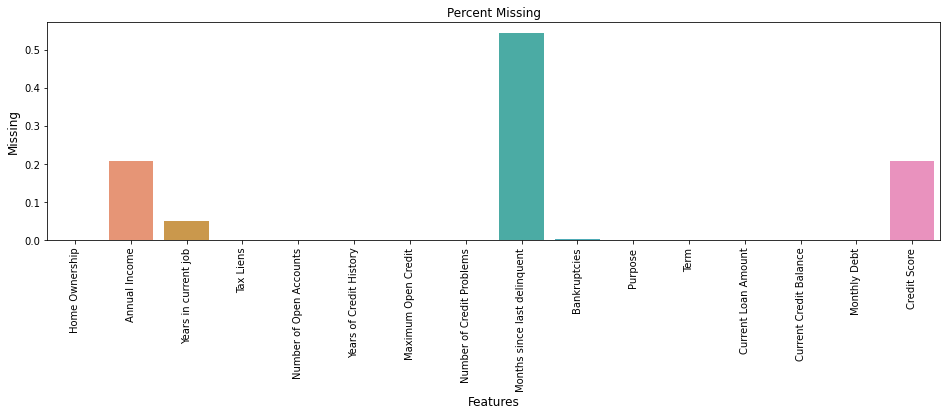

In [69]:
import seaborn as sns

nan_df = (X.isna().sum() / X.shape[0]).reset_index()
nan_df.columns=['feature', 'nan_percent']

plt.figure(figsize=(16,4))
sns.barplot(nan_df['feature'], nan_df['nan_percent'])
plt.title('Percent Missing')
plt.ylabel('Missing', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=90)
plt.show()


In [70]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Credit Default  7500 non-null   int64
dtypes: int64(1)
memory usage: 58.7 KB


In [182]:
def general_data_stat(X):
    print(f'Статистика по полям\n')
    
    bad_fields =[]
    missing_values_fields = {}
    for key in X:      
        col_type =  X[key].dtype        
        print(f'Поля "{key}"')
        print(f'Тип поля: {col_type}')
        cnt = X[X[key].notnull()].shape[0]
        all_cnt = X[key].shape[0]
        percent = cnt/all_cnt*100
        if percent < 60:
            bad_fields.append(key) 
        if percent < 100:
            missing_values_fields[key] = percent
        print(f'Обшие Количество {all_cnt}, не пустые {cnt}, доля заполняемости - {percent} ')
        if col_type != object:
            
            print("")
            
            print(f'Минимум : {X[key].min()}' )
            print(f'Максимум : {X[key].max()}' )
            print(f'Средние : {X[key].mean()}' )
            print("")
        print('-*'*50)
    
    print("")
    print(f'Поля пропуски более 40% {bad_fields}')
    s ='['
    for k,v in missing_values_fields.items():
        s +=f'{k} : {round(v,2)}%, '
    s +=']\n'
    print(f'Поля заполненые на: {s}')     
        
def unique_val_counts(X):
    print(f'Уникальные значения\n')
    for key in X:
        print(f'Поля "{key}"')
        print(f'Количество уникальных значений: {X[key].unique().shape[0]}' )
        print('-*'*50)

def data_draw(X):
   
    c = [i for i in range(X.shape[0])]
    for key in X:
        col_type =  X[key].dtype
        if col_type != object:
            plt.scatter(X[key], c);
            plt.title(key)
            plt.ylabel('Индекс', fontsize=12)
            plt.xlabel('Значения поля', fontsize=12)
            plt.show()

def data_zero(X):
          
    for key in X:
        col_type =  X[key].dtype
        if col_type != object:            
            c = X.loc[X[key]==0].shape[0]
            print(f'Поля "{key}"')
            print(f'Количество значений ноль: {c}')
            print('-*'*50)

def data_value_counts(X):
    print(f'Количество повторяющихся значений\n')      
    for key in X:     
        print(f'Поля "{key}"')
        print('-'*30)
        print(X[key].value_counts())
        print('-*'*50)


In [162]:
general_data_stat(X)

Статистика по полям

Поля "Home Ownership"
Тип поля: object
Обшие Количество 7500, не пустые 7500, доля заполнености - 100.0 
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Поля "Annual Income"
Тип поля: float64
Обшие Количество 7500, не пустые 5943, доля заполнености - 79.24 

Минимум : 164597.0
Максимум : 10149344.0
Средние : 1366391.7201749957

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Поля "Years in current job"
Тип поля: object
Обшие Количество 7500, не пустые 7129, доля заполнености - 95.05333333333333 
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Поля "Tax Liens"
Тип поля: float64
Обшие Количество 7500, не пустые 7500, доля заполнености - 100.0 

Минимум : 0.0
Максимум : 7.0
Средние : 0.030133333333333335

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Поля "N

In [163]:
general_data_stat(X)

Статистика по полям

Поля "Home Ownership"
Тип поля: object
Обшие Количество 7500, не пустые 7500, доля заполнености - 100.0 
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Поля "Annual Income"
Тип поля: float64
Обшие Количество 7500, не пустые 5943, доля заполнености - 79.24 

Минимум : 164597.0
Максимум : 10149344.0
Средние : 1366391.7201749957

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Поля "Years in current job"
Тип поля: object
Обшие Количество 7500, не пустые 7129, доля заполнености - 95.05333333333333 
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Поля "Tax Liens"
Тип поля: float64
Обшие Количество 7500, не пустые 7500, доля заполнености - 100.0 

Минимум : 0.0
Максимум : 7.0
Средние : 0.030133333333333335

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Поля "N

In [164]:
unique_val_counts(X)

Уникальные значения

Поля "Home Ownership"
Количество уникальных значений: 4
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Поля "Annual Income"
Количество уникальных значений: 5479
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Поля "Years in current job"
Количество уникальных значений: 12
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Поля "Tax Liens"
Количество уникальных значений: 8
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Поля "Number of Open Accounts"
Количество уникальных значений: 39
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Поля "Years of Credit History"
Количество уникальных значений: 408
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Поля "Maximu

In [165]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Credit Default  7500 non-null   int64
dtypes: int64(1)
memory usage: 58.7 KB


data_draw(X)

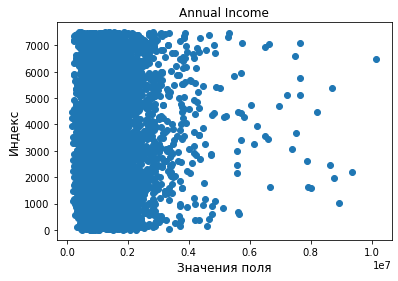

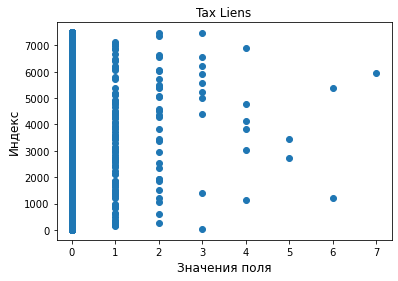

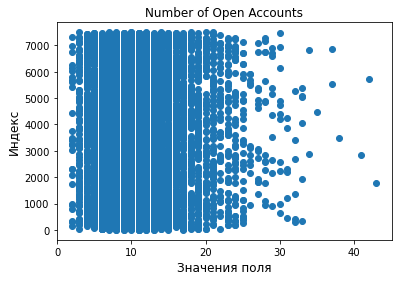

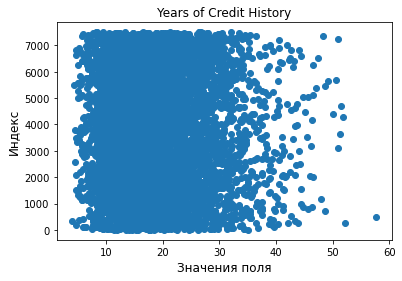

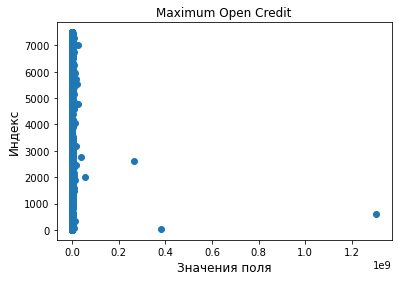

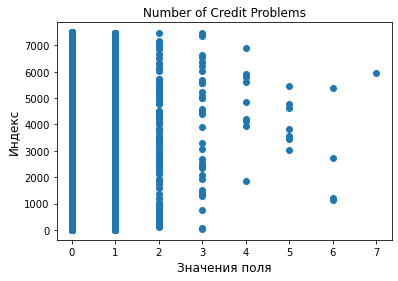

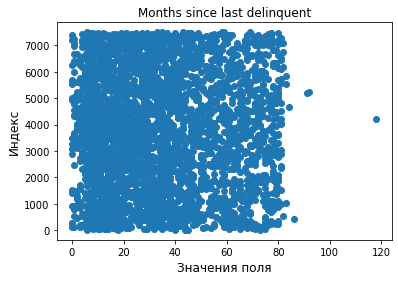

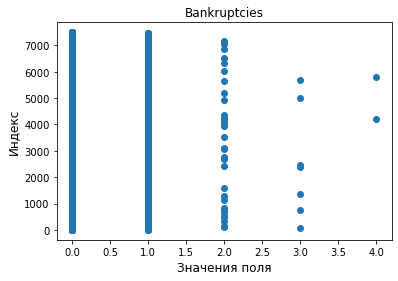

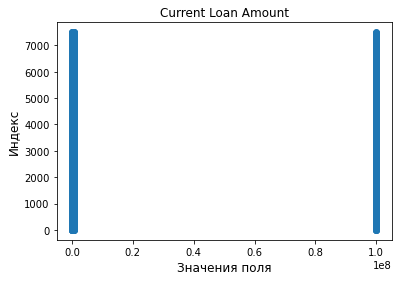

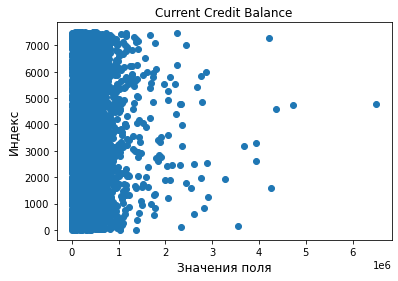

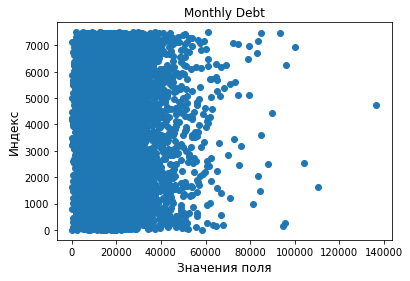

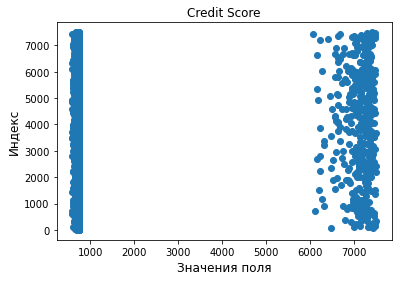

In [166]:
data_draw(X)

In [173]:
data_zero(X)

Поля "Annual Income"
Количество значений ноль: 0
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Поля "Tax Liens"
Количество значений ноль: 7366
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Поля "Number of Open Accounts"
Количество значений ноль: 0
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Поля "Years of Credit History"
Количество значений ноль: 0
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Поля "Maximum Open Credit"
Количество значений ноль: 65
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Поля "Number of Credit Problems"
Количество значений ноль: 6469
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Поля "Months since last delinquent"
Количество значений нол

In [183]:
data_value_counts(X)

Количество повторяющихся значений

Поля "Home Ownership"
------------------------------
Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Поля "Annual Income"
------------------------------
1161660.0    4
1058376.0    4
1338113.0    4
1043651.0    4
969475.0     4
            ..
1141254.0    1
7907382.0    1
1534478.0    1
972040.0     1
1654786.0    1
Name: Annual Income, Length: 5478, dtype: int64
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Поля "Years in current job"
------------------------------
10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
-*-*-*-*-*-*-*-*-*-*-*-*

### Вывод

1. В четырёх полях имеются пропуски  
Annual Income : 79.24%,
Years in current job : 95.05%, 
Months since last delinquent : 45.59%,
Bankruptcies : 99.81%, Credit Score : 79.24%, 
Поля Months since last delinquent заполнено на 45 процентов возможно это поля лучше убрать из расчётов
2. Выбросы наблюдаться в полях Annual Income,Tax Liens,
Number of Open Accounts, Years of Credit History,Number of Credit Problems,Maximum Open Credit,
Number of Credit Problems,Current Loan Amount,Current Credit Balance,Monthly Debt
3. неадекватные значения признака наблюдается 
"Current Loan Amount" 99999999.0   - 870 встречается это значения имеется большая разница между остальными значениями
"Maximum Open Credit"  0.0          65 Очень странное значения, если конечно этот признак не считает текущею кредитную историю
